# Manual temporal GNN using PyG

## Data generation code

In [1]:
import torch
from torch_geometric.data import Data, Dataset

class PouchTemporalDataset(Dataset):
    def __init__(self, Ca, edge_index):
        """
        Ca: numpy array, shape (N, T)
        edge_index: torch.LongTensor, shape (2, E)
        """
        super().__init__()
        self.Ca = torch.tensor(Ca, dtype=torch.float)      # (N, T)
        self.edge_index = edge_index
        self.T = Ca.shape[1]

    def len(self):
        # One data point per (t -> t+1)
        return self.T - 1

    def get(self, idx):
        # x = Ca at time t
        x = self.Ca[:, idx].unsqueeze(1)      # (N, 1)
        # y = Ca at time t+1
        y = self.Ca[:, idx+1].unsqueeze(1)    # (N, 1)

        return Data(
            x=x,
            y=y,
            edge_index=self.edge_index
        )


## GraphSAGE -> GRU -> Linear Model

In [2]:
import torch
import torch.nn as nn
from torch_geometric.nn import SAGEConv

class SAGE_GRU_Autoregressive(nn.Module):
    def __init__(self, in_channels=1, hidden_channels=32):
        super().__init__()

        # Spatial aggregator (GraphSAGE)
        self.sage = SAGEConv(in_channels, hidden_channels)

        # Temporal recurrence per node
        self.gru = nn.GRU(hidden_channels, hidden_channels, batch_first=True)

        # Decoder back to Ca(t+1)
        self.lin = nn.Linear(hidden_channels, 1)

        self.hidden_channels = hidden_channels

    def forward(self, x_t, edge_index, h):
        """
        x_t: (N, 1) – Ca at time t
        edge_index: graph edges
        h: (1, N, hidden_dim) – GRU hidden state
        """

        # 1) Spatial message passing
        g = self.sage(x_t, edge_index)       # (N, H)
        g = torch.relu(g)

        # 2) GRU expects (batch, sequence, features)
        g_seq = g.unsqueeze(0)               # (1, N, H)
        out, h_new = self.gru(g_seq, h)      # out: (1, N, H)

        # 3) Predict next Calcium
        pred = self.lin(out.squeeze(0))      # (N, 1)

        return pred, h_new

    def init_hidden(self, N):
        return torch.zeros(1, N, self.hidden_channels)


In [3]:
class SAGE_GRU_Autoregressive2(nn.Module):
    def __init__(self, in_channels=1, hidden_channels=32):
        super().__init__()

        self.sage = SAGEConv(in_channels, hidden_channels)

        # GRU per node (each node is a batch element)
        self.gru = nn.GRU(hidden_channels, hidden_channels, batch_first=False)

        self.lin = nn.Linear(hidden_channels, 1)
        self.hidden_channels = hidden_channels

    def forward(self, x_t, edge_index, h):
        # Spatial step
        g = self.sage(x_t, edge_index)   # (N, H)
        g = torch.relu(g)

        # Make seq_len=1, batch=N
        g_seq = g.unsqueeze(0)           # (1, N, H)

        # GRU
        out, h_new = self.gru(g_seq, h)  # h shape: (1, N, H)

        # Decode next state
        pred = self.lin(out.squeeze(0))  # (N,1)

        return pred, h_new

    def init_hidden(self, N):
        return torch.zeros(1, N, self.hidden_channels)


## Training Loop

In [4]:
from torch_geometric.loader import DataLoader

def train_model(model, dataset, epochs=50, lr=1e-3):
    loader = DataLoader(dataset, batch_size=1, shuffle=False)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    N = dataset.Ca.shape[0]   # number of cells
    print(f"Training on {N} nodes.")

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0

        # Reset GRU hidden state each epoch
        h = model.init_hidden(N)

        for data in loader:
            x = data.x          # (N,1)
            y = data.y          # (N,1)
            edge_index = data.edge_index

            pred, h = model(x, edge_index, h)

            loss = loss_fn(pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch}: Loss = {total_loss:.6f}")


In [5]:
def train_model2(model, dataset, epochs=50, lr=1e-3):
    loader = DataLoader(dataset, batch_size=1, shuffle=False)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    N = dataset.Ca.shape[0]

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0

        h = model.init_hidden(N)

        for data in loader:
            x = data.x
            y = data.y
            edge_index = data.edge_index

            # Forward
            pred, h = model(x, edge_index, h)

            # ⛔ CRITICAL: Detach hidden state so graph doesn't grow across timesteps
            h = h.detach()

            # Compute loss
            loss = loss_fn(pred, y)

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch}: Loss = {total_loss:.6f}")

## Autoregressive Rollout for Testing

In [6]:
def autoregressive_rollout(model, x0, edge_index, steps=200):
    """
    x0: (N,1) initial Ca frame
    """
    model.eval()

    N = x0.shape[0]
    h = model.init_hidden(N)

    x_t = x0
    preds = [x0.detach().cpu().numpy()]

    for _ in range(steps):
        x_next, h = model(x_t, edge_index, h)
        preds.append(x_next.detach().cpu().numpy())
        x_t = x_next

    # returns array (steps+1, N, 1)
    return np.stack(preds, axis=1)


# Pipeline

## Load a simulation output

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

ca_models_lib_mac = "/Users/scini/Documents/GitHub/Systems_Bio/ca_models_lib.py" 
ca_models_lib_path = ca_models_lib_mac  # Change this if on a different system

# Add the directory containing ca_models_lib.py to sys.path
import sys
import os
if ca_models_lib_path not in sys.path:
    sys.path.append(os.path.dirname(ca_models_lib_path))

import ca_models_lib as caml

import pandas as pd
import time


In [8]:
# Load data
folder_path_pc = r"C:\Users\steph\Box\ZartmanLabGroupFolder\Zartman_Dowling\Stephen\MC2021_Data"
folder_path_mac = r"/Users/scini/Library/CloudStorage/Box-Box/ZartmanLabGroupFolder/Zartman_Dowling/Stephen/MC2021_Data"

folder_path = folder_path_mac
# Get geometry files

# Select size
size = 'xsmall'  # Options: 'xsmall', 'small', 'medium', 'large',
# Load statics for wing disc geometries    
disc_vertices = np.load(os.path.join(folder_path, "geometry", "disc_vertices.npy"), allow_pickle=True).item()  # Vertices
disc_laplacians = np.load(os.path.join(folder_path, "geometry", "disc_sizes_laplacian.npy"), allow_pickle=True).item()  # Laplacian Matrix
disc_adjs = np.load(os.path.join(folder_path, "geometry", "disc_sizes_adj.npy"), allow_pickle=True).item()  # Adjacency matrix

adj_matrix=disc_adjs[size] # Adjacency Matrix
laplacian_matrix=disc_laplacians[size] # Laplacian Matrix
new_vertices=disc_vertices[size] # Vertices

# Number of cells
num_cells = new_vertices.shape[0]

In [9]:
disc_model_dense = caml.PouchModelScipy_dense(laplacian_matrix, sim_time=3600, dt=1, 
                                              t_eval_boolean=True, random_seed=123456  
                                              ) 

In [10]:
t_sim = time.perf_counter()
sig2 = disc_model_dense.simulate()
print(f"Step 2 took {time.perf_counter() - t_sim:.4f} seconds")

Step 2 took 32.0756 seconds


In [11]:
stim_cells2 = disc_model_dense.stimulated_cell_idxs

print(stim_cells2)

[175  66 173]


In [12]:
# print(Ca_conc.shape, IP3_conc.shape, R_conc.shape)
time_points2 = sig2.t
Ca_conc2 = sig2.y[:num_cells, :]
IP3_conc2 = sig2.y[num_cells:2*num_cells, :]
R_conc2 = sig2.y[2*num_cells:, :]

print(Ca_conc2.shape, IP3_conc2.shape, R_conc2.shape)

(195, 3600) (195, 3600) (195, 3600)


In [13]:
# Add 1% Gaussian noise
np.random.seed(123456)  # For reproducibility
Ca_conc2_noisy = Ca_conc2 + np.random.normal(0, 0.01 * np.std(Ca_conc2), Ca_conc2.shape)

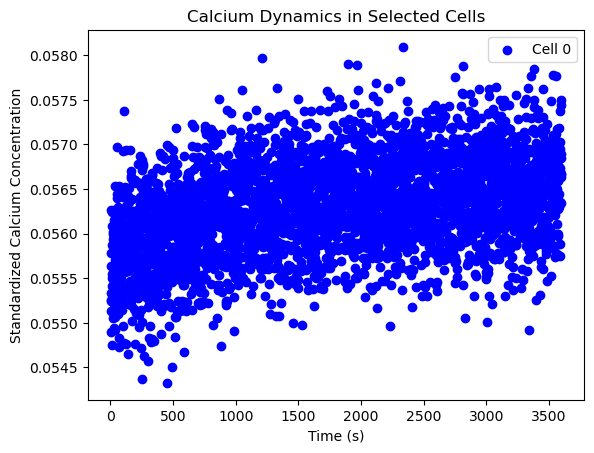

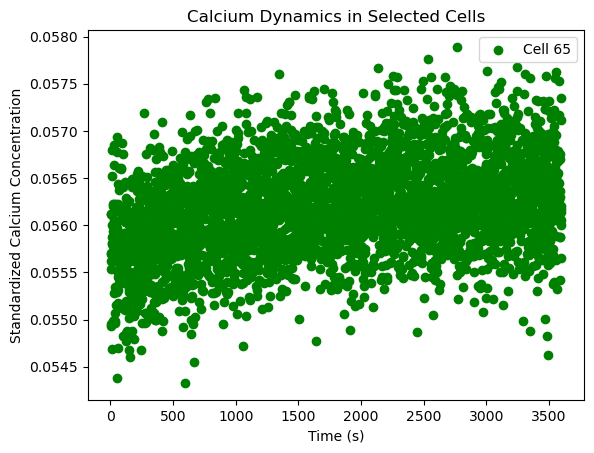

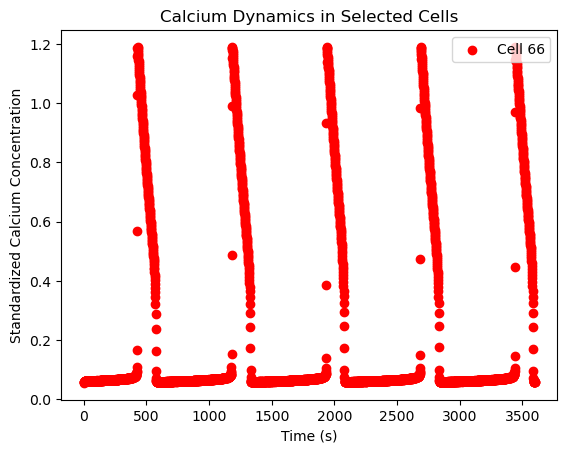

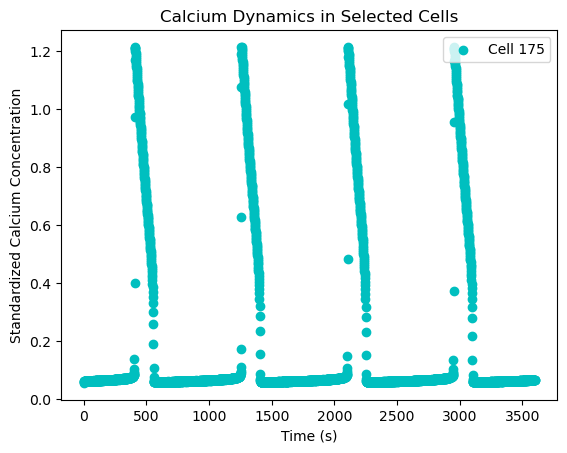

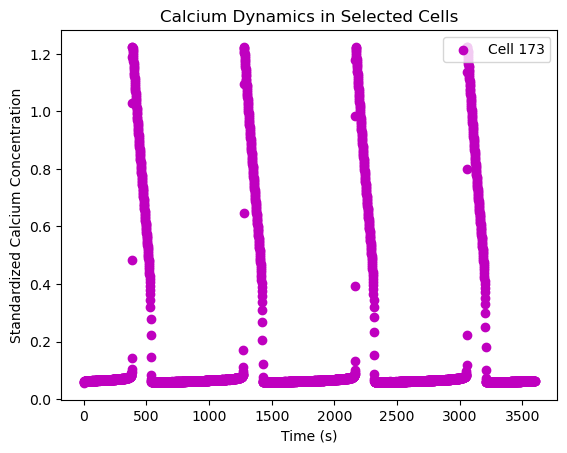

In [14]:
# Plot a few example cells to visualize the calcium dynamics

cell_indices = [0, 65, 66, 175 ,173 ]  # Example cell indices
colors = ['b', 'g', 'r', 'c', 'm']
for i in cell_indices:
    plt.scatter(time_points2[1:], Ca_conc2_noisy[i, 1:], label=f'Cell {i}', color=colors[cell_indices.index(i) % len(colors)])
    plt.xlabel('Time (s)')
    plt.ylabel('Standardized Calcium Concentration')
    plt.title('Calcium Dynamics in Selected Cells')
    plt.legend()
    plt.show()


In [15]:
off_diag_lap = laplacian_matrix - np.diag(np.diag(laplacian_matrix))
display(off_diag_lap)

is_symmetric = np.allclose(off_diag_lap, off_diag_lap.T)
print("Symmetric?", is_symmetric)

row, col = np.nonzero(off_diag_lap)
# np.array(row)
# np.array(col)

edge_index = torch.tensor([row, col], dtype=torch.long)
print(edge_index)
print(edge_index.shape)  # Should be [2, num_edges]
edge_weight = torch.tensor(off_diag_lap[row, col], dtype=torch.float32)


print(edge_weight)
print(edge_weight.shape)  # Should be [num_edges,]

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , 10.19337977],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ..., 10.19337977,
         0.        ,  0.        ]], shape=(195, 195))

Symmetric? True
tensor([[  0,   0,   1,  ..., 194, 194, 194],
        [  3,   5,   3,  ..., 188, 189, 192]])
torch.Size([2, 1064])
tensor([ 8.6643,  9.5087,  8.8120,  ...,  8.8206,  7.3286, 10.1934])
torch.Size([1064])


/var/folders/v2/s6clf_y12bjd0pq98kr66skw0000gs/T/ipykernel_13217/737813101.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1724788636709/work/torch/csrc/utils/tensor_new.cpp:281.)
  edge_index = torch.tensor([row, col], dtype=torch.long)


In [16]:
# Build PouchTemporalDataset
dataset = PouchTemporalDataset(Ca_conc2_noisy, edge_index)

In [17]:
# Make the model and train it
model = SAGE_GRU_Autoregressive2(in_channels=1, hidden_channels=32)
train_model2(model, dataset, epochs=50, lr=1e-3)

Epoch 0: Loss = 0.752786
Epoch 1: Loss = 0.040955
Epoch 2: Loss = 0.028716
Epoch 3: Loss = 0.027155
Epoch 4: Loss = 0.065116
Epoch 5: Loss = 0.021521
Epoch 6: Loss = 0.096635
Epoch 7: Loss = 0.040015
Epoch 8: Loss = 0.036276
Epoch 9: Loss = 0.061795
Epoch 10: Loss = 0.053411
Epoch 11: Loss = 0.046629
Epoch 12: Loss = 0.041845
Epoch 13: Loss = 0.020894
Epoch 14: Loss = 0.008527
Epoch 15: Loss = 0.007757
Epoch 16: Loss = 0.007345
Epoch 17: Loss = 0.009866
Epoch 18: Loss = 0.010694
Epoch 19: Loss = 0.007432
Epoch 20: Loss = 0.005352
Epoch 21: Loss = 0.009041
Epoch 22: Loss = 0.008537
Epoch 23: Loss = 0.008856
Epoch 24: Loss = 0.006462
Epoch 25: Loss = 0.004714
Epoch 26: Loss = 0.007122
Epoch 27: Loss = 0.007591
Epoch 28: Loss = 0.004167
Epoch 29: Loss = 0.007616
Epoch 30: Loss = 0.009282
Epoch 31: Loss = 0.006114
Epoch 32: Loss = 0.004681
Epoch 33: Loss = 0.006490
Epoch 34: Loss = 0.003250
Epoch 35: Loss = 0.008784
Epoch 36: Loss = 0.004485
Epoch 37: Loss = 0.007183
Epoch 38: Loss = 0.004

In [18]:
# Autoregressive rollout
x0 = torch.tensor(Ca_conc2_noisy[:, 0]).unsqueeze(1).float()  # (N,1)
preds = autoregressive_rollout(model, x0, edge_index, steps=Ca_conc2_noisy.shape[1]-1)

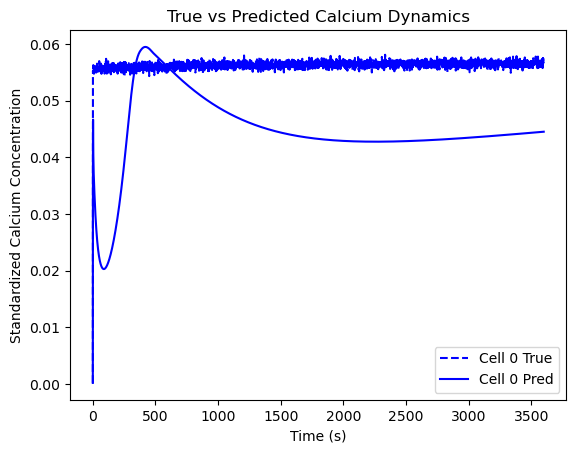

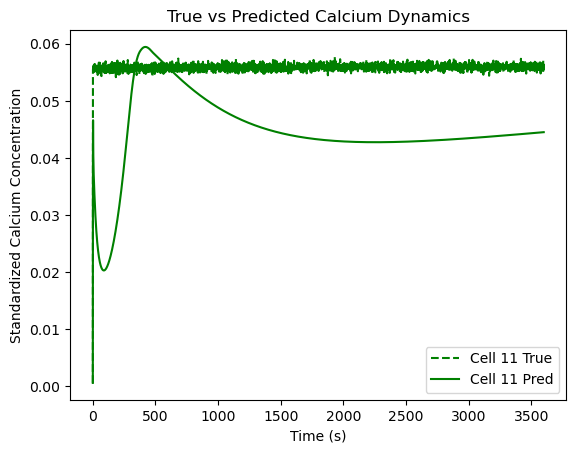

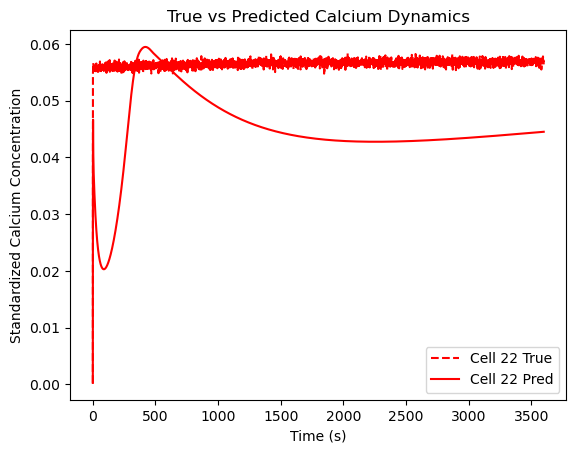

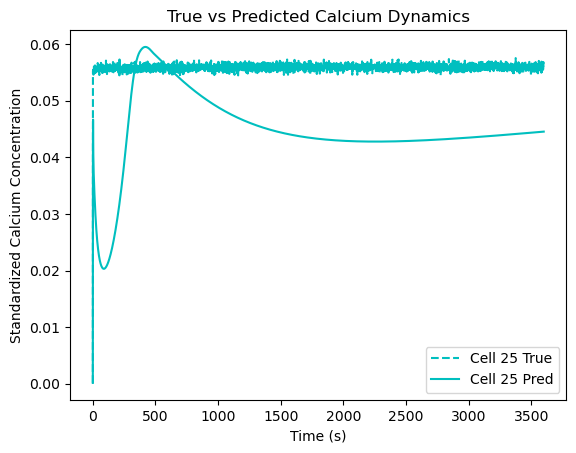

In [19]:
# Plot results for a few example cells
cell_indices = [0, 11, 22, 25 ]  #Example cell indices
colors = ['b', 'g', 'r', 'c', 'm']
for i in cell_indices:
    plt.plot(time_points2, Ca_conc2_noisy[i, :], label=f'Cell {i} True', color=colors[cell_indices.index(i) % len(colors)], linestyle='--')
    plt.plot(time_points2, preds[i, :, 0], label=f'Cell {i} Pred', color=colors[cell_indices.index(i) % len(colors)], linestyle='-')
    plt.xlabel('Time (s)')
    plt.ylabel('Standardized Calcium Concentration')
    plt.title('True vs Predicted Calcium Dynamics')
    plt.legend()
    plt.show()

## Normal training, no autoregression

In [20]:
def train_model_nextstep(model, dataset, epochs=50, lr=1e-3):
    loader = DataLoader(dataset, batch_size=1, shuffle=True)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    N = dataset.Ca.shape[0]   # number of nodes/cells

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0

        for data in loader:

            x = data.x          # (N,1)
            y = data.y          # (N,1)
            edge_index = data.edge_index

            # Reset hidden state EVERY time
            h = model.init_hidden(N)

            pred, h = model(x, edge_index, h)

            loss = loss_fn(pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch}: loss = {total_loss:.6f}")


In [21]:
def evaluate_nextstep(model, dataset):
    loader = DataLoader(dataset, batch_size=1, shuffle=False)
    model.eval()

    N = dataset.Ca.shape[0]
    preds, truths = [], []

    with torch.no_grad():
        for data in loader:
            x = data.x
            y = data.y
            edge_index = data.edge_index

            h = model.init_hidden(N)    # reset!
            pred, h = model(x, edge_index, h)

            preds.append(pred.cpu())
            truths.append(y.cpu())

    return preds, truths

In [22]:
T_train = 3000
Ca = Ca_conc2_noisy

train_set = PouchTemporalDataset(Ca[:, :T_train], edge_index)
test_set  = PouchTemporalDataset(Ca[:, T_train-1:], edge_index)

# Save train and test sets
# torch.save(train_set, 'pouch_train_set_nextstep_11202025.pt')
# torch.save(test_set, 'pouch_test_set_nextstep_11202025.pt')

In [23]:
# Train next-step model
model_nextstep = SAGE_GRU_Autoregressive2(in_channels=1, hidden_channels=32)
train_model_nextstep(model_nextstep, train_set, epochs=50, lr=1e-3)


Epoch 0: loss = 0.456611
Epoch 1: loss = 0.042722
Epoch 2: loss = 0.044916
Epoch 3: loss = 0.041842
Epoch 4: loss = 0.041131
Epoch 5: loss = 0.039932
Epoch 6: loss = 0.039134
Epoch 7: loss = 0.038952
Epoch 8: loss = 0.039061
Epoch 9: loss = 0.038020
Epoch 10: loss = 0.037884
Epoch 11: loss = 0.038238
Epoch 12: loss = 0.037773
Epoch 13: loss = 0.037714
Epoch 14: loss = 0.038364
Epoch 15: loss = 0.036752
Epoch 16: loss = 0.037849
Epoch 17: loss = 0.037661
Epoch 18: loss = 0.037499
Epoch 19: loss = 0.036697
Epoch 20: loss = 0.036949
Epoch 21: loss = 0.037368
Epoch 22: loss = 0.036461
Epoch 23: loss = 0.037353
Epoch 24: loss = 0.036688
Epoch 25: loss = 0.037002
Epoch 26: loss = 0.036427
Epoch 27: loss = 0.036976
Epoch 28: loss = 0.036393
Epoch 29: loss = 0.036642
Epoch 30: loss = 0.036604
Epoch 31: loss = 0.036697
Epoch 32: loss = 0.036222
Epoch 33: loss = 0.036270
Epoch 34: loss = 0.036485
Epoch 35: loss = 0.035906
Epoch 36: loss = 0.036452
Epoch 37: loss = 0.035888
Epoch 38: loss = 0.036

In [24]:
# Test the model preds, truths = evaluate_nextstep(model_nextstep, test_set)
preds_list, truths_list = evaluate_nextstep(model_nextstep, test_set)

In [25]:
# Convert lists of (N,1) tensors into arrays
truths_arr = torch.stack([t.squeeze(1) for t in truths_list], dim=1).numpy()  # (N, T_test)
preds_arr  = torch.stack([p.squeeze(1) for p in preds_list],  dim=1).numpy()  # (N, T_test)

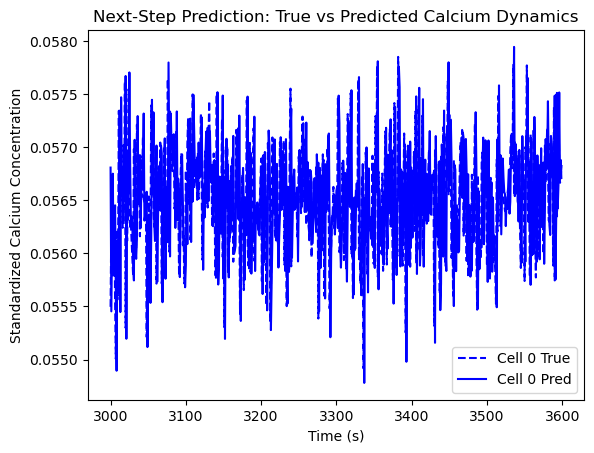

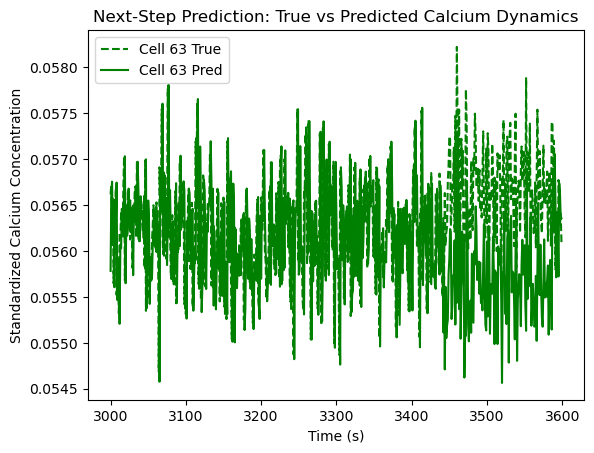

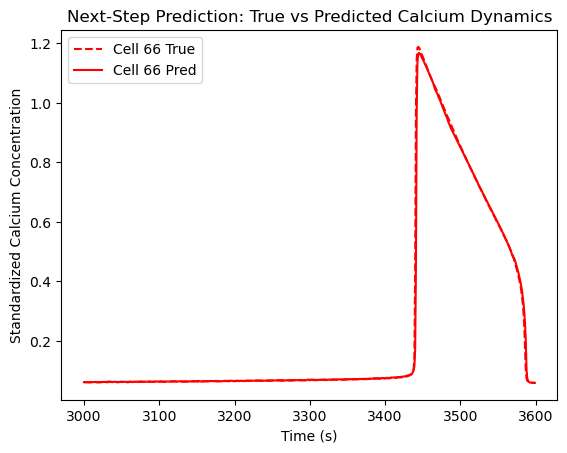

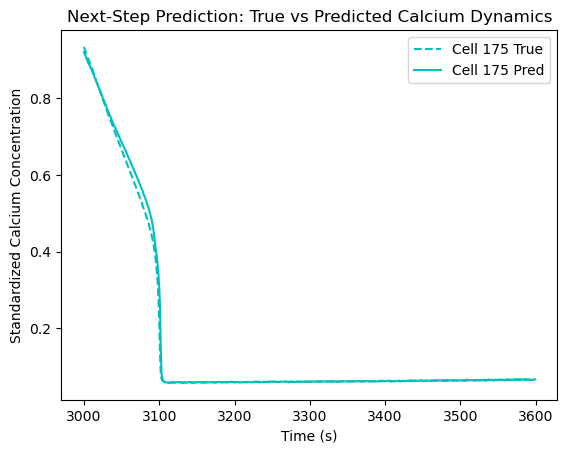

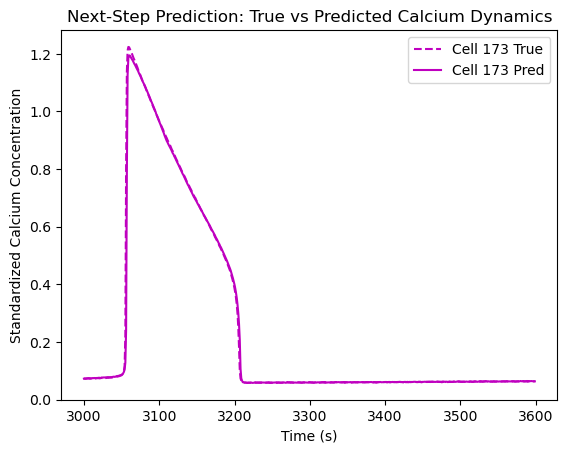

In [26]:
# Plot results for a few example cells
timepoints_test = time_points2[T_train:]

cell_indices = [0, 63, 66, 175, 173 ]  #Example cell indices
colors = ['b', 'g', 'r', 'c', 'm']
for i in cell_indices:
    plt.plot(timepoints_test, truths_arr[i, :], label=f'Cell {i} True', color=colors[cell_indices.index(i) % len(colors)], linestyle='--')
    plt.plot(timepoints_test, preds_arr[i, :], label=f'Cell {i} Pred', color=colors[cell_indices.index(i) % len(colors)], linestyle='-')
    plt.xlabel('Time (s)')
    plt.ylabel('Standardized Calcium Concentration')
    plt.title('Next-Step Prediction: True vs Predicted Calcium Dynamics')
    plt.legend()
    plt.show()

## Generate videos

In [43]:
import matplotlib
import seaborn as sns
from matplotlib import animation
from matplotlib import colors

def make_animation(ca, vertices, interval=50, normalize_flag=True): # Creation of calcium video
    colormap = plt.cm.Greens
    if normalize_flag:
        normalize = matplotlib.colors.Normalize(vmin=np.min(ca), vmax=max(np.max(ca),1))
    else:
        normalize = matplotlib.colors.Normalize(vmin=-np.max(np.abs(ca)), vmax=np.max(np.abs(ca)))
    with sns.axes_style("white"):
            fig=plt.figure(figsize=(25,15))
            fig.patch.set_alpha(0.)
            ax = fig.add_subplot(1,1,1)
            ax.axis('off')
            sm = plt.cm.ScalarMappable(cmap=colormap, norm=normalize)
            sm._A = []
            cbar=fig.colorbar(sm, ax=ax)
            cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), fontsize=15,fontweight="bold")
            for cell in vertices:
                ax.plot(cell[:,0],cell[:,1], linewidth=0.0, color='w', alpha = 0.0)
            patches = [matplotlib.patches.Polygon(verts) for verts in vertices ]
                    # Timestamp generator, 1 sec increments
            def time_stamp_gen(n):
                for j in range(n):
                    if j%10==0:
                        yield f"Elapsed time: {j//60:02d}:{j%60:02d}"
            time_stamps=time_stamp_gen(len(ca[0,:]))
            def init():
                return [ax.add_patch(p) for p in patches]

            def animate(frame,time_stamps):
                for j in range(len(patches)):
                    c=colors.to_hex(colormap(normalize(frame[j])), keep_alpha=False)
                    patches[j].set_facecolor(c)
                ax.set_title( next(time_stamps) ,fontsize=50, fontweight="bold")
                return patches

            anim = animation.FuncAnimation(fig, animate, 
                                            init_func=init, 
                                            frames=ca[:,::10].T, # Calcium dynamics: [n cells x time-samples]
                                            fargs=(time_stamps,),
                                            interval=interval,
                                            blit=True)
            
            return anim

/var/folders/v2/s6clf_y12bjd0pq98kr66skw0000gs/T/ipykernel_13217/487646521.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), fontsize=15,fontweight="bold")


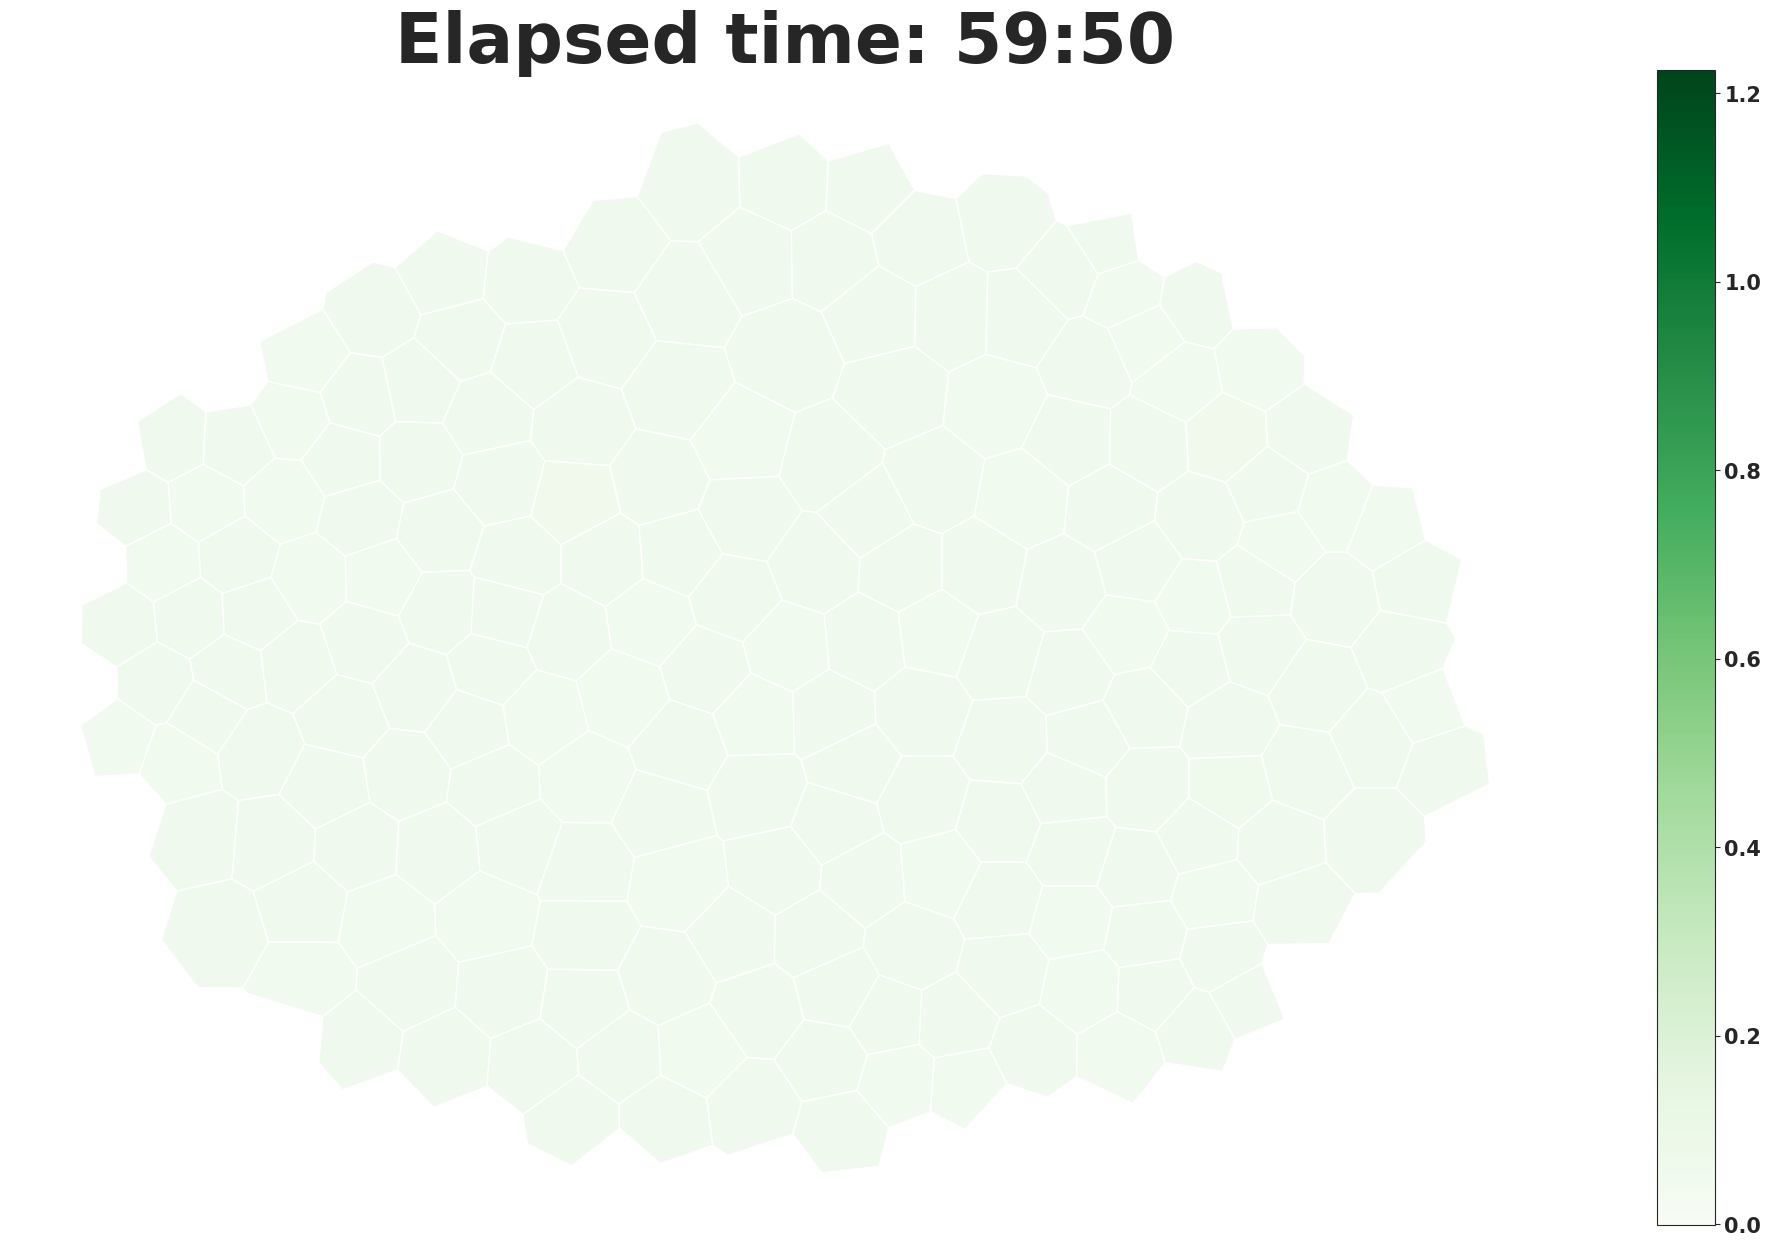

In [28]:
true_anim = make_animation(Ca_conc2_noisy, new_vertices)

# Save animation
true_anim.save('true_calcium_dynamics.mp4', writer='ffmpeg', dpi=200)

/var/folders/v2/s6clf_y12bjd0pq98kr66skw0000gs/T/ipykernel_13217/487646521.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), fontsize=15,fontweight="bold")
/var/folders/v2/s6clf_y12bjd0pq98kr66skw0000gs/T/ipykernel_13217/487646521.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), fontsize=15,fontweight="bold")


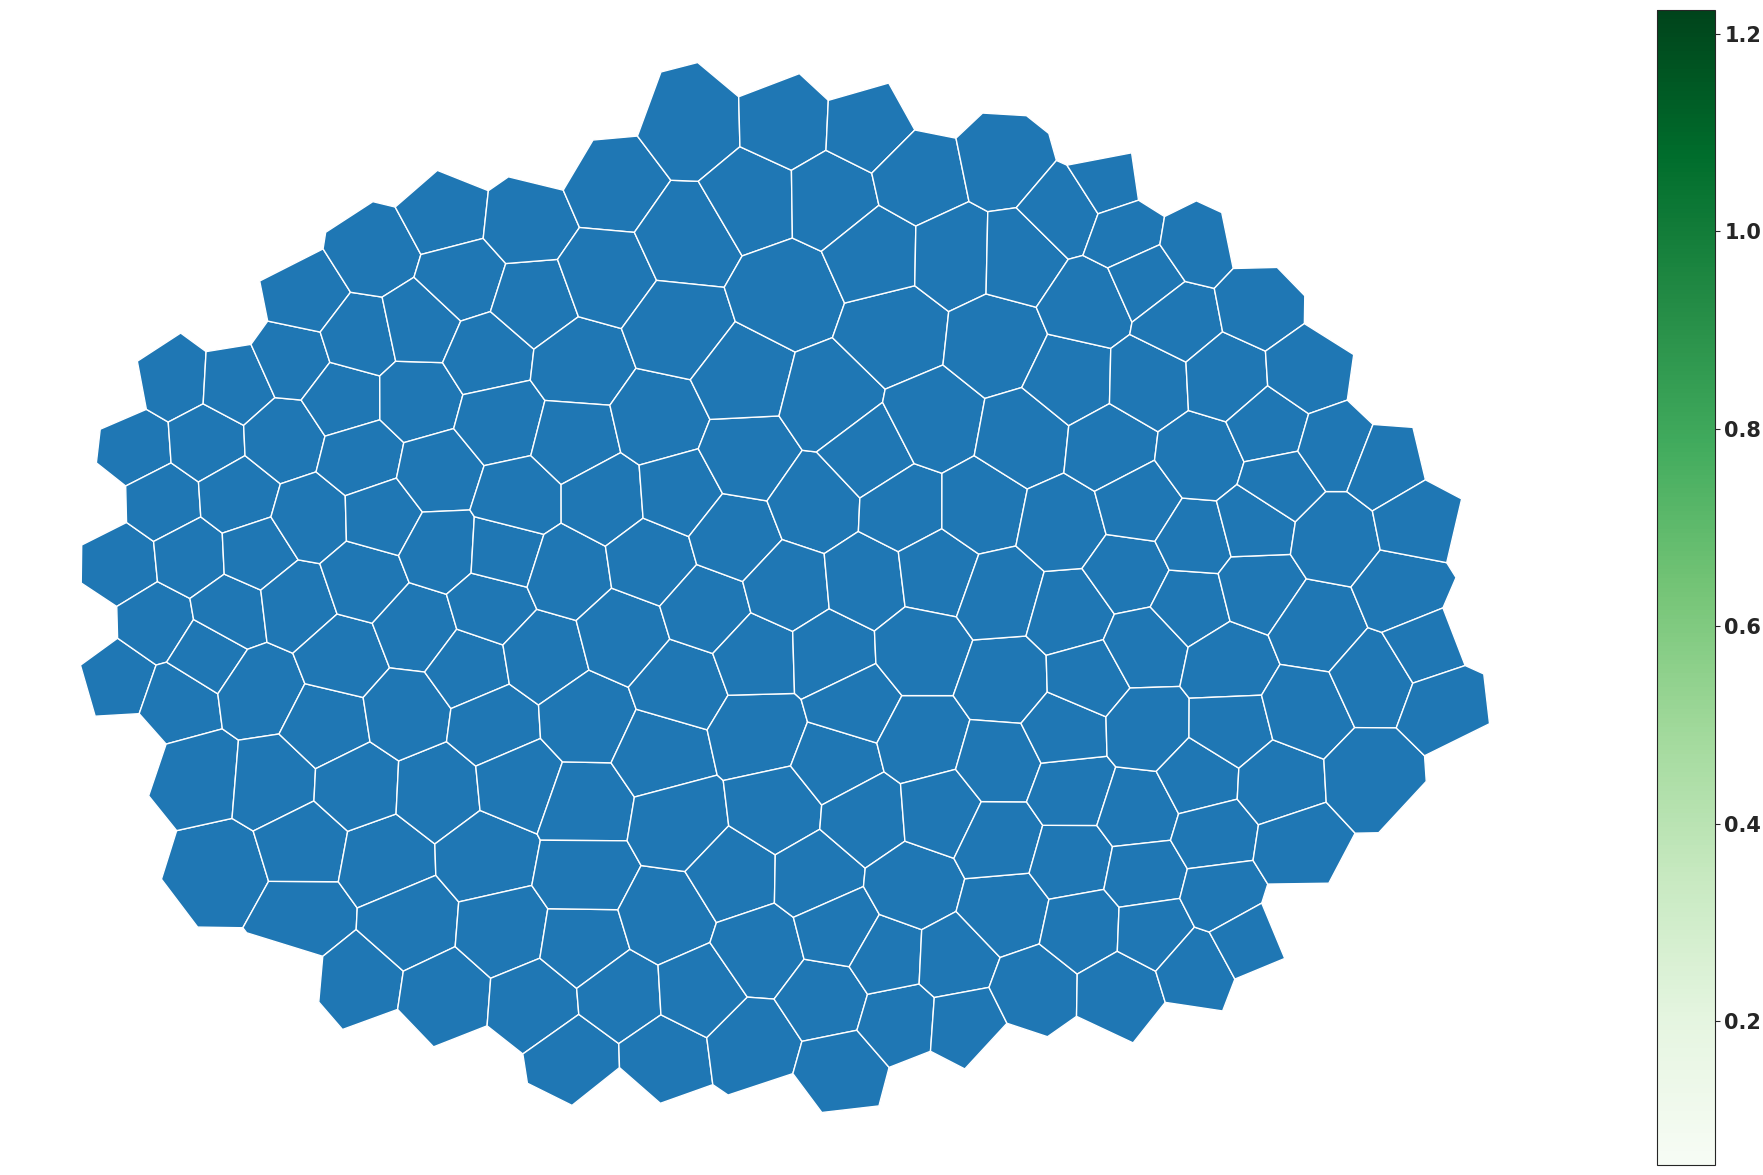

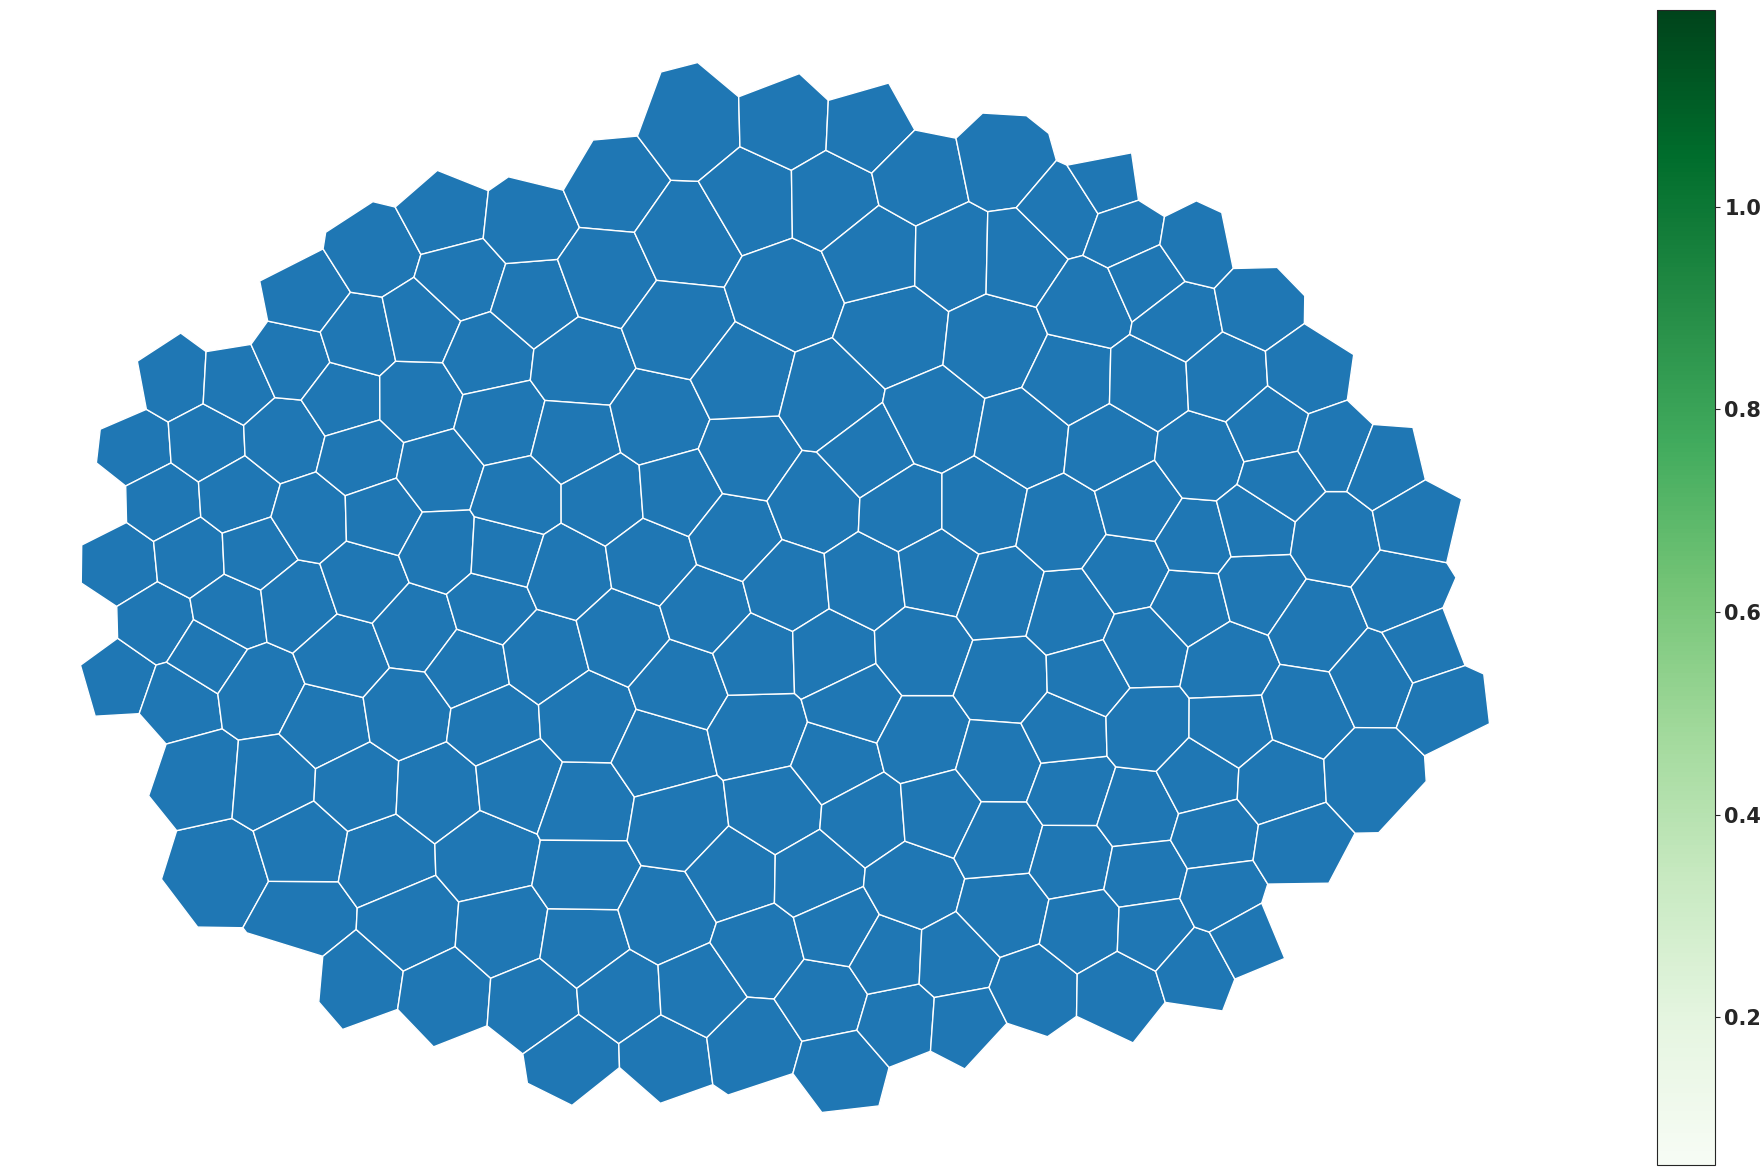

In [29]:
truth_anim = make_animation(truths_arr, new_vertices, interval=100)
# Save animation
# truth_anim.save('true_calcium_dynamics_nextstep.mp4', writer='ffmpeg',
#                     dpi=200)
preds_anim = make_animation(preds_arr, new_vertices, interval=100)
# Save animation
# preds_anim.save('predicted_calcium_dynamics_nextstep.mp4', writer='ffmpeg',
#                     dpi=200)

## Test with higher VPLC simulation

In [30]:
wave_params = {
    'lower': 0.4,
    'upper': 0.8,
}

wave_pouch = caml.PouchModelScipy_dense(laplacian_matrix, sim_time=3600, dt=1,
                                t_eval_boolean=True,
                                param_dict=wave_params,
                                random_seed=123456
                                )

t_sim = time.perf_counter()
sig_wave = wave_pouch.simulate()
print(f"Wave simulation took {time.perf_counter() - t_sim:.4f} seconds")

Wave simulation took 138.1582 seconds


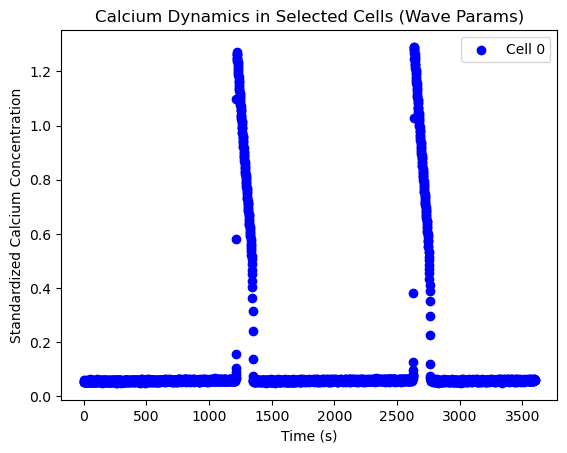

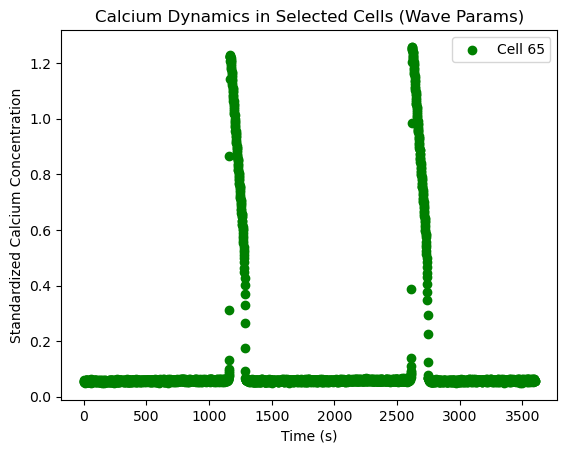

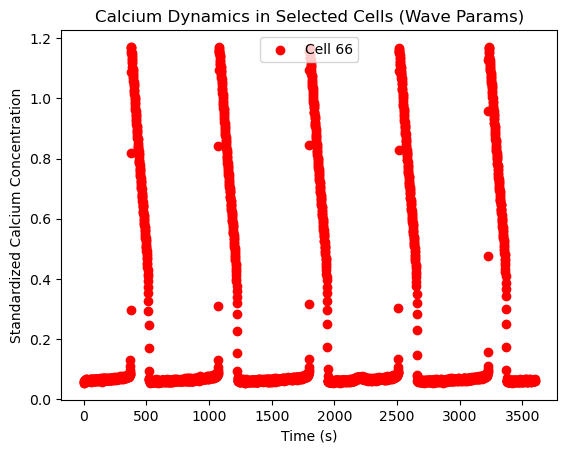

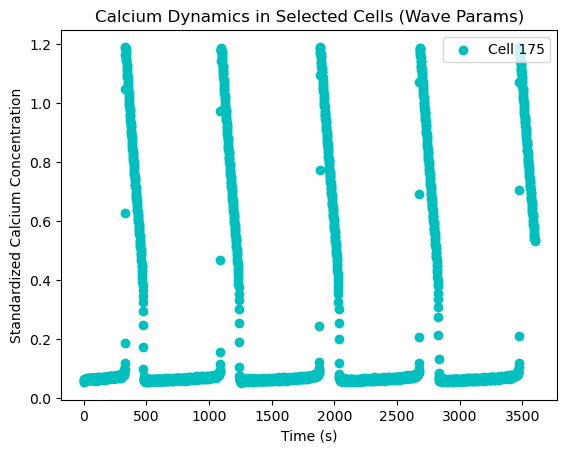

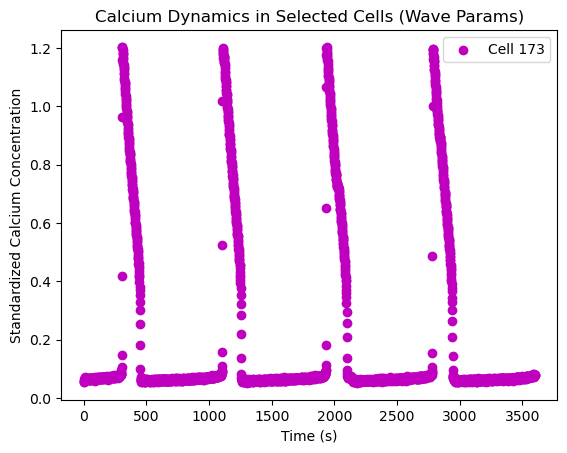

In [31]:
# Extract Calcium concentration
ca_wave = sig_wave.y[:num_cells, :]
# Add noise
np.random.seed(123456)
ca_wave_noisy = ca_wave + np.random.normal(0, 0.01 * np.std(ca_wave), ca_wave.shape)

# Plot a few example cells to visualize the calcium dynamics
cell_indices = [0, 65, 66, 175 ,173 ]  # Example cell indices
colors = ['b', 'g', 'r', 'c', 'm']
for i in cell_indices:
    plt.scatter(time_points2[1:], ca_wave_noisy[i, 1:], label=f'Cell {i}', color=colors[cell_indices.index(i) % len(colors)])
    plt.xlabel('Time (s)')
    plt.ylabel('Standardized Calcium Concentration')
    plt.title('Calcium Dynamics in Selected Cells (Wave Params)')
    plt.legend()
    plt.show()

In [32]:
# Make animation of wave dynamics
# wave_anim = make_animation(ca_wave_noisy, new_vertices, interval=50)
# # Save animation
# wave_anim.save('wave_calcium_dynamics.mp4', writer='ffmpeg',
#                     dpi=200)

In [33]:
# Make ca_wave_noisy into a PouchTemporalDataset
wave_dataset = PouchTemporalDataset(ca_wave_noisy, edge_index)

# # Save wave_dataset for future use
# torch.save(wave_dataset, 'wave_pouch_temporal_dataset11202025.pt')

# Evaluate next-step model on wave data
wave_preds_list, wave_truths_list = evaluate_nextstep(model_nextstep, wave_dataset)
wave_truths_arr = torch.stack([t.squeeze(1) for t in wave_truths_list], dim=1).numpy()  # (N, T_wave)
wave_preds_arr  = torch.stack([p.squeeze(1) for p in wave_preds_list
],  dim=1).numpy()  # (N, T_wave)

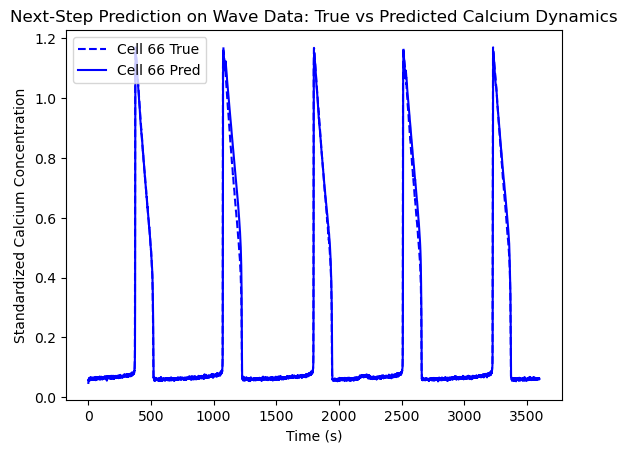

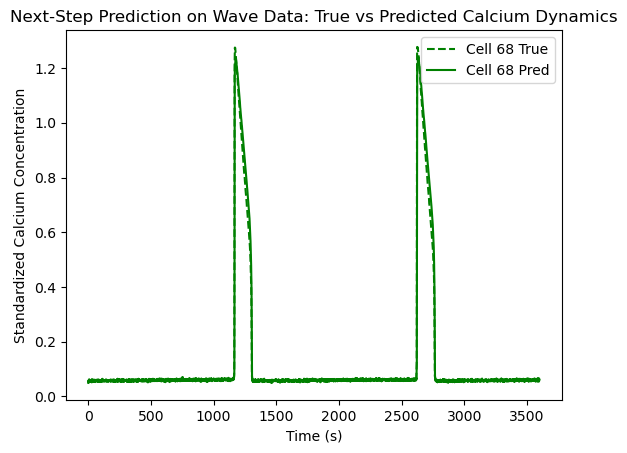

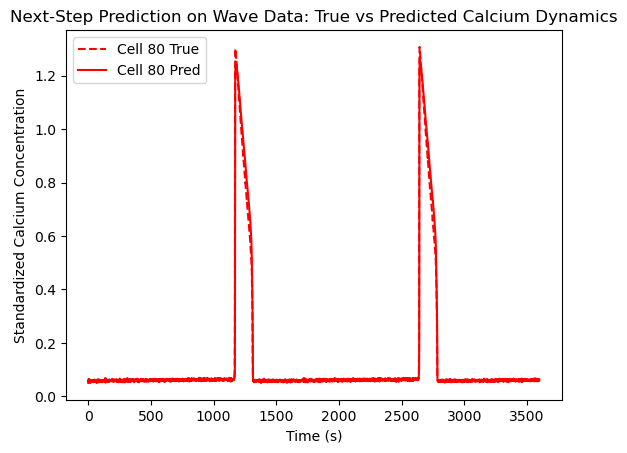

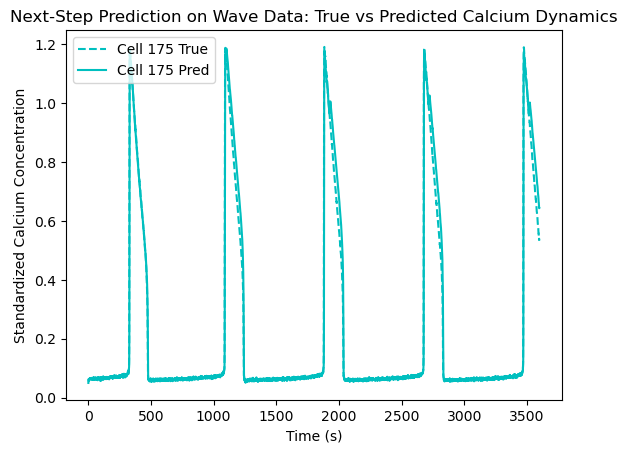

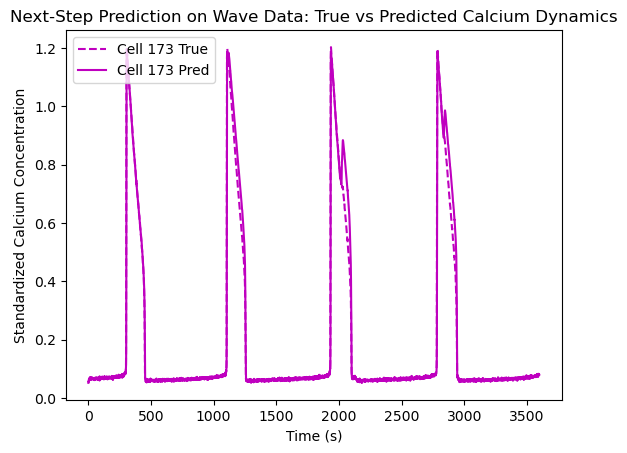

In [34]:
# Plot results for a few example cells
timepoints_wave = time_points2[1:wave_truths_arr.shape[1]+1]
cell_indices = [66, 68,  80, 175, 173,]  #Example cell indices
colors = ['b', 'g', 'r', 'c', 'm']
for i in cell_indices:
    plt.plot(timepoints_wave, wave_truths_arr[i, :], label=f'Cell {i} True', color=colors[cell_indices.index(i) % len(colors)], linestyle='--')
    plt.plot(timepoints_wave, wave_preds_arr[i, :], label=f'Cell {i} Pred', color=colors[cell_indices.index(i) % len(colors)], linestyle='-')
    plt.xlabel('Time (s)')
    plt.ylabel('Standardized Calcium Concentration')
    plt.title('Next-Step Prediction on Wave Data: True vs Predicted Calcium Dynamics')
    plt.legend()
    plt.show()

In [35]:
# Make animation of wave dynamics for next-step predictions
# wave_preds_anim = make_animation(wave_preds_arr, new_vertices, interval=50)
# Save animation
# wave_preds_anim.save('wave_predicted_calcium_dynamics_nextstep.mp4', writer='ffmpeg',
#                     dpi=200)

In [36]:
# # Take difference of preds and truths
# diff_arr = wave_preds_arr - wave_truths_arr

# # Make animation of difference
# diff_anim = make_animation(diff_arr, new_vertices, interval=50, normalize_flag=False)
# Save animation
# diff_anim.save('wave_difference_calcium_dynamics_nextstep.mp4', writer='ffmpeg',
#                     dpi=200)

In [93]:
from sklearn.ensemble import RandomForestClassifier
# Use Random Forest classifier to predict the initiator cells

# make model with sklearn
rf_model = RandomForestClassifier(n_estimators=100, random_state=123456, oob_score=True, warm_start=True)

# Prepare training data
X_train = Ca_conc2_noisy.T # Shape: (timesteps, num_cells)
y_train = np.zeros(X_train.shape[0])  # Initialize labels
print(X_train.shape[1])
y_train[stim_cells2] = 1  # Mark initiator cells

print("True initiator cells:", stim_cells2)

rf_model.fit(X_train, y_train)

# Plot feature importances
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Print top features
for f in range(X_train.shape[1]):
    print(f"Feature {indices[f]}: Importance {importances[indices[f]]:.4f}")
# plt.figure(figsize=(50, 6))
# plt.title("Feature Importances from Random Forest")
# plt.bar(range(X_train.shape[1]), importances[indices], align='center')
# plt.xticks(range(X_train.shape[1]), indices)
# # turn labels diagonal
# plt.xticks(rotation=45, fontsize=12)
# plt.xlabel("Feature Index (Cell Index)", fontsize=14)
# plt.ylabel("Importance Score", fontsize=14)
# plt.show()


195
True initiator cells: [175  66 173]
Feature 168: Importance 0.0409
Feature 81: Importance 0.0315
Feature 135: Importance 0.0280
Feature 148: Importance 0.0259
Feature 40: Importance 0.0258
Feature 163: Importance 0.0240
Feature 55: Importance 0.0230
Feature 3: Importance 0.0227
Feature 84: Importance 0.0204
Feature 93: Importance 0.0197
Feature 190: Importance 0.0195
Feature 96: Importance 0.0182
Feature 27: Importance 0.0181
Feature 122: Importance 0.0173
Feature 98: Importance 0.0162
Feature 53: Importance 0.0154
Feature 149: Importance 0.0151
Feature 50: Importance 0.0149
Feature 94: Importance 0.0144
Feature 101: Importance 0.0137
Feature 8: Importance 0.0135
Feature 127: Importance 0.0135
Feature 186: Importance 0.0132
Feature 22: Importance 0.0132
Feature 70: Importance 0.0128
Feature 24: Importance 0.0125
Feature 145: Importance 0.0121
Feature 119: Importance 0.0118
Feature 141: Importance 0.0116
Feature 47: Importance 0.0109
Feature 12: Importance 0.0109
Feature 61: Importa

In [ ]:

# Now evaluate on wave data
X_wave = wave_preds_arr.T  # Shape: (num_cells, time_steps)
y_wave_pred = rf_model.predict(X_wave)
# print("Predicted labels for wave data:", y_wave_pred)
print("Predicted initiator cells in wave data:", np.where(y_wave_pred == 1)[0])

# Print ROC AUC score
from sklearn.metrics import roc_auc_score
y_wave_true = np.zeros(X_wave.shape[0])
y_wave_true[stim_cells2] = 1  # True initiator cells
roc_auc = roc_auc_score(y_wave_true, y_wave_pred)
print(f"ROC AUC Score on Wave Data: {roc_auc:.4f}")



Predicted initiator cells in wave data: [  0 173 175]
ROC AUC Score on Wave Data: 0.8332


In [94]:
# Train with X_wave = wave_preds_arr.T  # Shape: (num_cells, time_steps)
rf_model.fit(X_wave, y_wave_true,)

# See importances again
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
# Print top features
for f in range(X_wave.shape[1]):
    print(f"Feature {indices[f]}: Importance {importances[indices[f]]:.4f}")

Feature 168: Importance 0.0409
Feature 81: Importance 0.0315
Feature 135: Importance 0.0280
Feature 148: Importance 0.0259
Feature 40: Importance 0.0258
Feature 163: Importance 0.0240
Feature 55: Importance 0.0230
Feature 3: Importance 0.0227
Feature 84: Importance 0.0204
Feature 93: Importance 0.0197
Feature 190: Importance 0.0195
Feature 96: Importance 0.0182
Feature 27: Importance 0.0181
Feature 122: Importance 0.0173
Feature 98: Importance 0.0162
Feature 53: Importance 0.0154
Feature 149: Importance 0.0151
Feature 50: Importance 0.0149
Feature 94: Importance 0.0144
Feature 101: Importance 0.0137
Feature 8: Importance 0.0135
Feature 127: Importance 0.0135
Feature 186: Importance 0.0132
Feature 22: Importance 0.0132
Feature 70: Importance 0.0128
Feature 24: Importance 0.0125
Feature 145: Importance 0.0121
Feature 119: Importance 0.0118
Feature 141: Importance 0.0116
Feature 47: Importance 0.0109
Feature 12: Importance 0.0109
Feature 61: Importance 0.0106
Feature 188: Importance 0.010

/Applications/anaconda3/envs/saifall2025-mac/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:465: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(


In [39]:
# Evaluate on very different dataset
# (e.g., different parameters or geometry)
complex_params = {
    'lower': 0.4,
    'upper': 0.8,
    'frac': 0.3,
    'K_PLC': 0.2,
}

complex_pouch = caml.PouchModelScipy_dense(laplacian_matrix, sim_time=3600, dt=1,
                                t_eval_boolean=True,
                                param_dict=complex_params,
                                random_seed=528491,
                                )

t_sim_c = time.perf_counter()
sig_complex = complex_pouch.simulate()
print(f"Complex simulation took {time.perf_counter() - t_sim_c:.4f} seconds")


Complex simulation took 225.1810 seconds


[  9 163  65  12  49 145 181  36  12  31 116  78  72 178  51  42  14 150
 193 155 130 106 106 144 139 165 100 171 121  33  98 194  90  68  96  97
  32 134 159 155 138  32  28  13  49  81  46  39  45  67  29 192  10 181
  56 153  22 130]
58


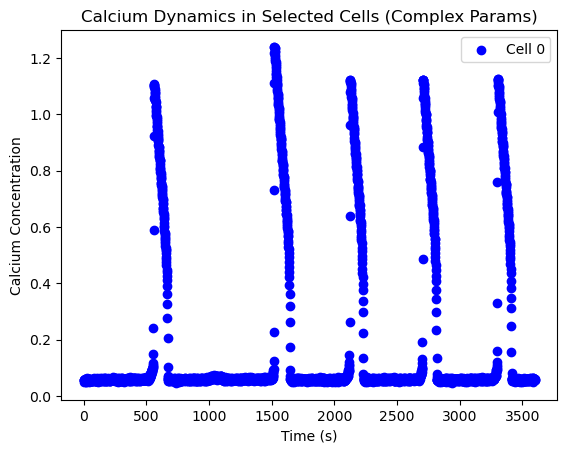

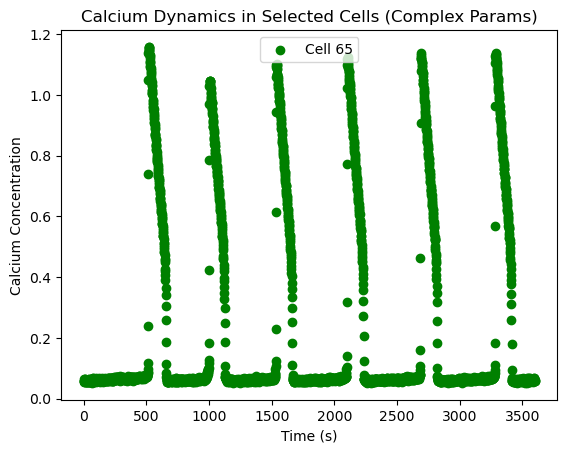

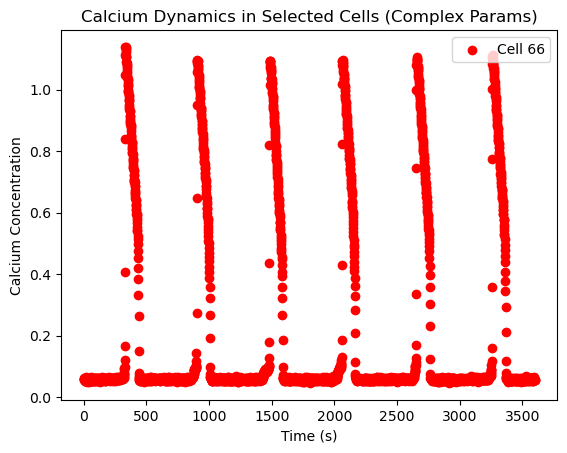

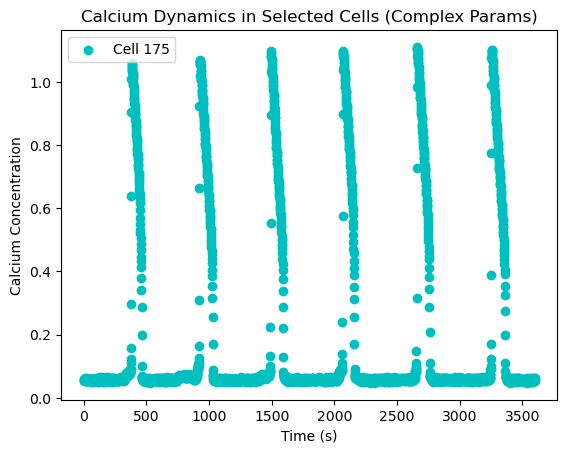

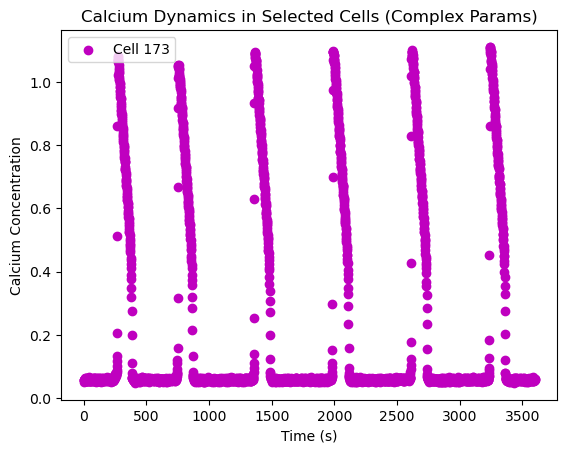

58


In [72]:
stim_cells_complex = complex_pouch.stimulated_cell_idxs
print(stim_cells_complex)
print(len(stim_cells_complex))

# Extract Calcium concentration
ca_complex = sig_complex.y[:num_cells, :]
# Add noise
np.random.seed(528491)
ca_complex_noisy = ca_complex + np.random.normal(0, 0.01 * np.std(ca_complex), ca_complex.shape)

# Plot a few example cells to visualize the calcium dynamics
cell_indices = [0, 65, 66, 175 ,173 ]  # Example cell indices
colors = ['b', 'g', 'r', 'c', 'm']
for i in cell_indices:
    plt.scatter(time_points2[1:], ca_complex_noisy[i, 1:], label=f'Cell {i}', color=colors[cell_indices.index(i) % len(colors)])
    plt.xlabel('Time (s)')
    plt.ylabel('Calcium Concentration')
    plt.title('Calcium Dynamics in Selected Cells (Complex Params)')
    plt.legend()
    plt.show()

print(len(stim_cells_complex))

In [95]:
# Now evaluate on complex data
X_complex = ca_complex_noisy.T  # Shape: (num_cells, time_steps)
y_complex_pred = rf_model.predict(X_complex)
init_c_pred = np.where(y_complex_pred == 1)[0]
print("Predicted initiator cells in complex data:", init_c_pred)
print(len(init_c_pred))
# Print ROC AUC score
y_complex_true = np.zeros(X_complex.shape[0])
y_complex_true[stim_cells_complex] = 1  # True initiator cells
roc_auc_complex = roc_auc_score(y_complex_true, y_complex_pred)
print(f"ROC AUC Score on Complex Data: {roc_auc_complex:.4f}")

Predicted initiator cells in complex data: []
0
ROC AUC Score on Complex Data: 0.5000


In [90]:
# Now, train with complex data, and see if we can recover wave initiators
rf_model2 = RandomForestClassifier(n_estimators=100, random_state=123456, oob_score=True)
rf_model2.fit(X_complex, y_complex_true)
# Evaluate on wave data again
y_wave_pred2 = rf_model2.predict(X_wave)
print("Predicted initiator cells in wave data (from complex-trained model):", np.where(y_wave_pred2 == 1)[0])   

Predicted initiator cells in wave data (from complex-trained model): []


/var/folders/v2/s6clf_y12bjd0pq98kr66skw0000gs/T/ipykernel_13217/487646521.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), fontsize=15,fontweight="bold")


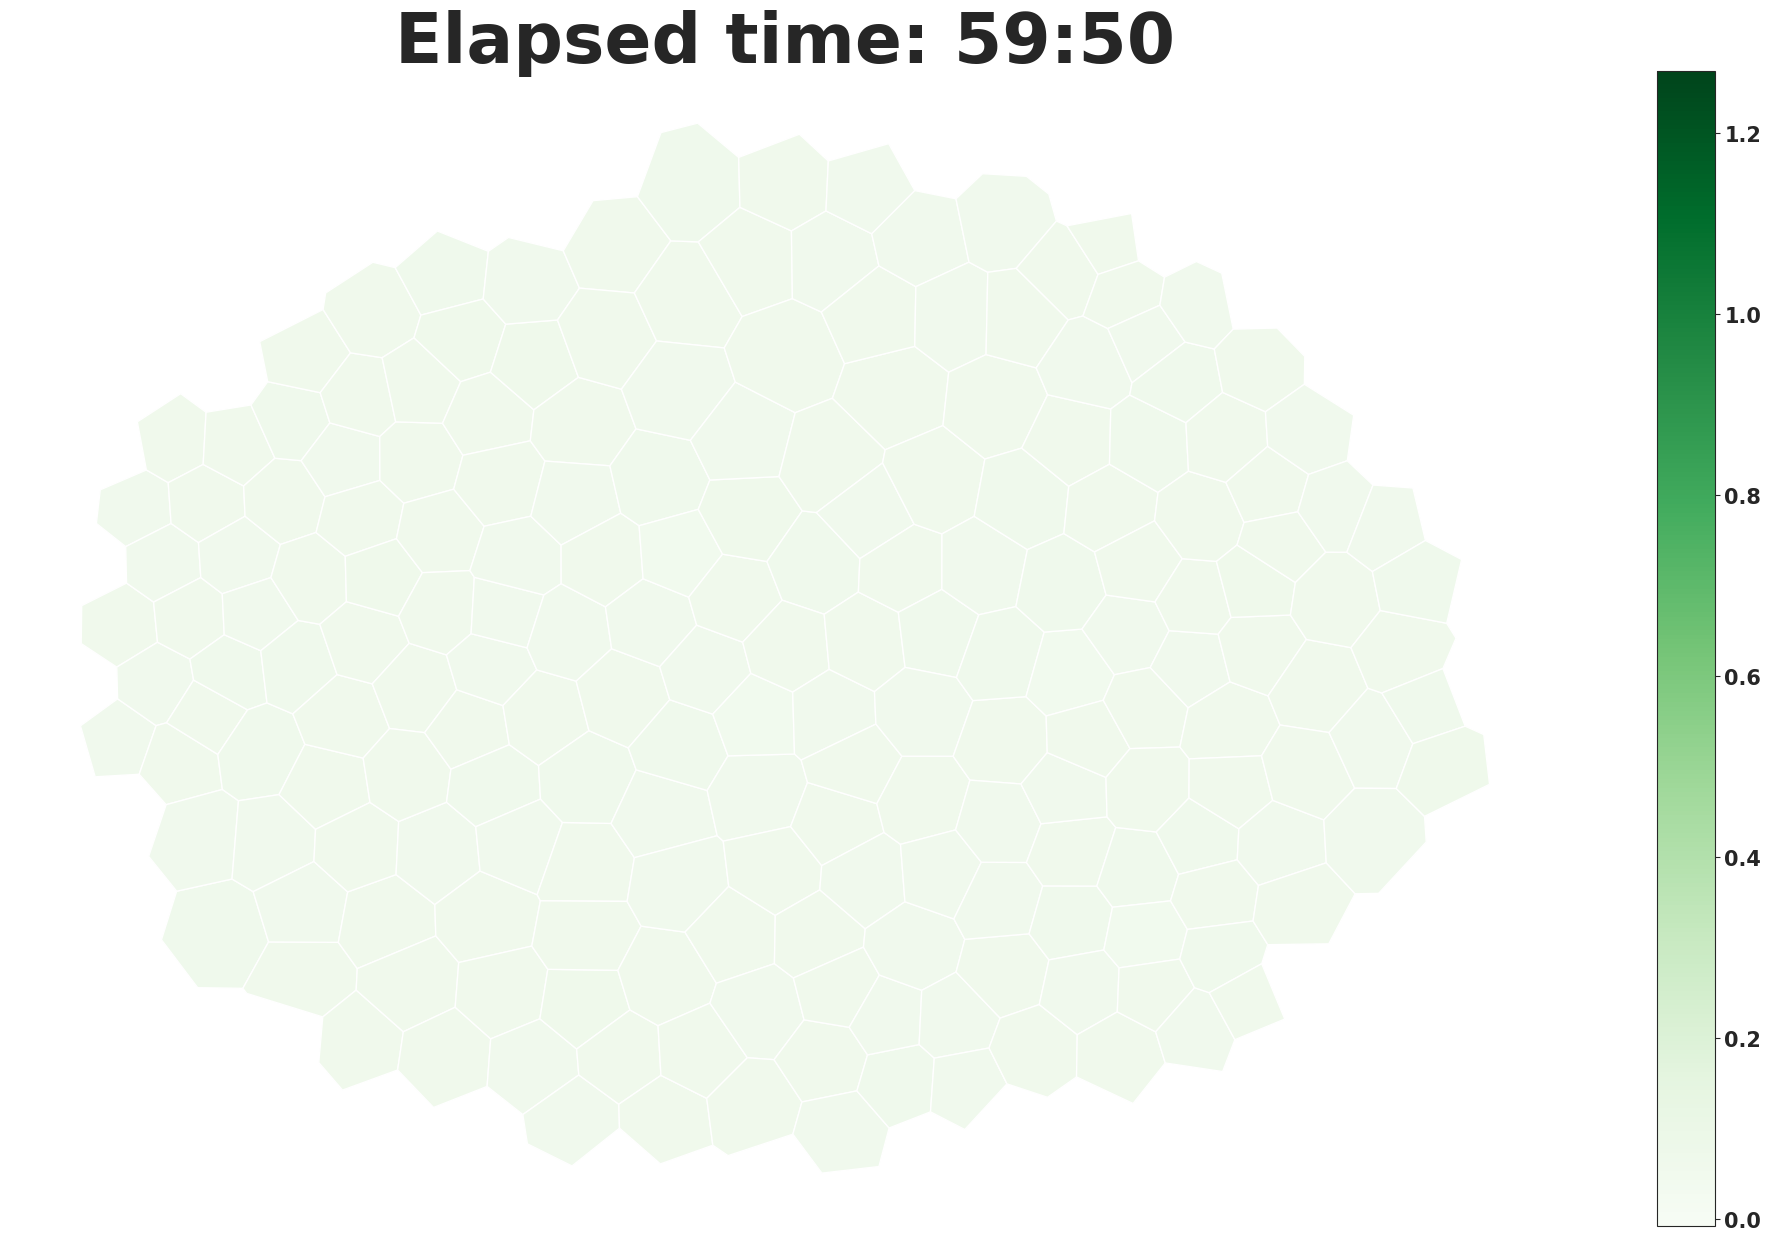

In [45]:
# Make animation for complex data wave dynamics
complex_anim = make_animation(ca_complex_noisy, new_vertices, interval=50)
# Save animation
complex_anim.save('complex_calcium_dynamics.mp4', writer='ffmpeg',
                    dpi=200)